In [2]:
import numpy as np
import pandas as pd
from sklearn.base import clone

import seaborn as sns


import optuna
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import *
from scipy.stats import linregress

import re

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.impute import SimpleImputer

SEED = 42
n_splits = 5

In [3]:
## watch data
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,NaN,71.0,70.0,104.0,NaN,NaN,NaN,NaN,Fall,16.0,0.0,18.0,1.0,19.9,2.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,Fall,3.0,4.52277,16.3642,1206.880,2051.70,19.46110,70.8117,14.0629,2.30138,11.58830,1.0,33.3709,17.97970,66.2889,29.7790,52.8320,NaN,NaN,Winter,3.260,Winter,3.0,3.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,32.

In [4]:
usable_data = train[train['sii'].notnull()]
usable_data

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.061430,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.211720,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.220330,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,NaN,60.0,73.0,102.0,NaN,NaN,NaN,NaN,Summer,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,Summer,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.498800,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,NaN,NaN,Spring,4.110,Summer,3.0,3.0,3.0,0.0,2.0,1.0,0.0,2.0,2.0,1.0,0.0,1.0,3.0,3.0,2.0,1.0,3.0,1.0,2.0,1.0,34.0,Summer,40.0,56.0,Spring,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,ff6c2bb8,Fall,8,0,NaN,NaN,Fall,17.139810,52.5,67.2,25.0,60.0,65.0,112.0,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,8.0,1.0,10.0,1.0,12.0,1.0,Fall,3.0,3.20303,17.1417,1035.270,1759.96,11.00630,52.5331,13.4004,3.741300,14.66690,1.0,25.7118,15.81500,49.3301,20.2645,36.7181,NaN,NaN,Fal

In [5]:
missing_count = (usable_data.isnull().sum().reset_index().rename(columns={'index': 'feature', 0:'null_count'}))
missing_count['null_ratio'] = missing_count['null_count'] / len(usable_data)
missing_count = missing_count.sort_values('null_count', ascending=False)
missing_count

,feature,null_count,null_ratio
51,PAQ_A-PAQ_A_Total,2373,0.867325
50,PAQ_A-Season,2373,0.867325
10,Physical-Waist_Circumference,2253,0.823465
16,Fitness_Endurance-Time_Mins,2008,0.733918
17,Fitness_Endurance-Time_Sec,2008,0.733918
...,...,...,...
1,Basic_Demos-Enroll_Season,0,0.000000
3,Basic_Demos-Sex,0,0.000000
75,PCIAT-PCIAT_Total,0,0.000000
54,PCIAT-Season,0,0.000000


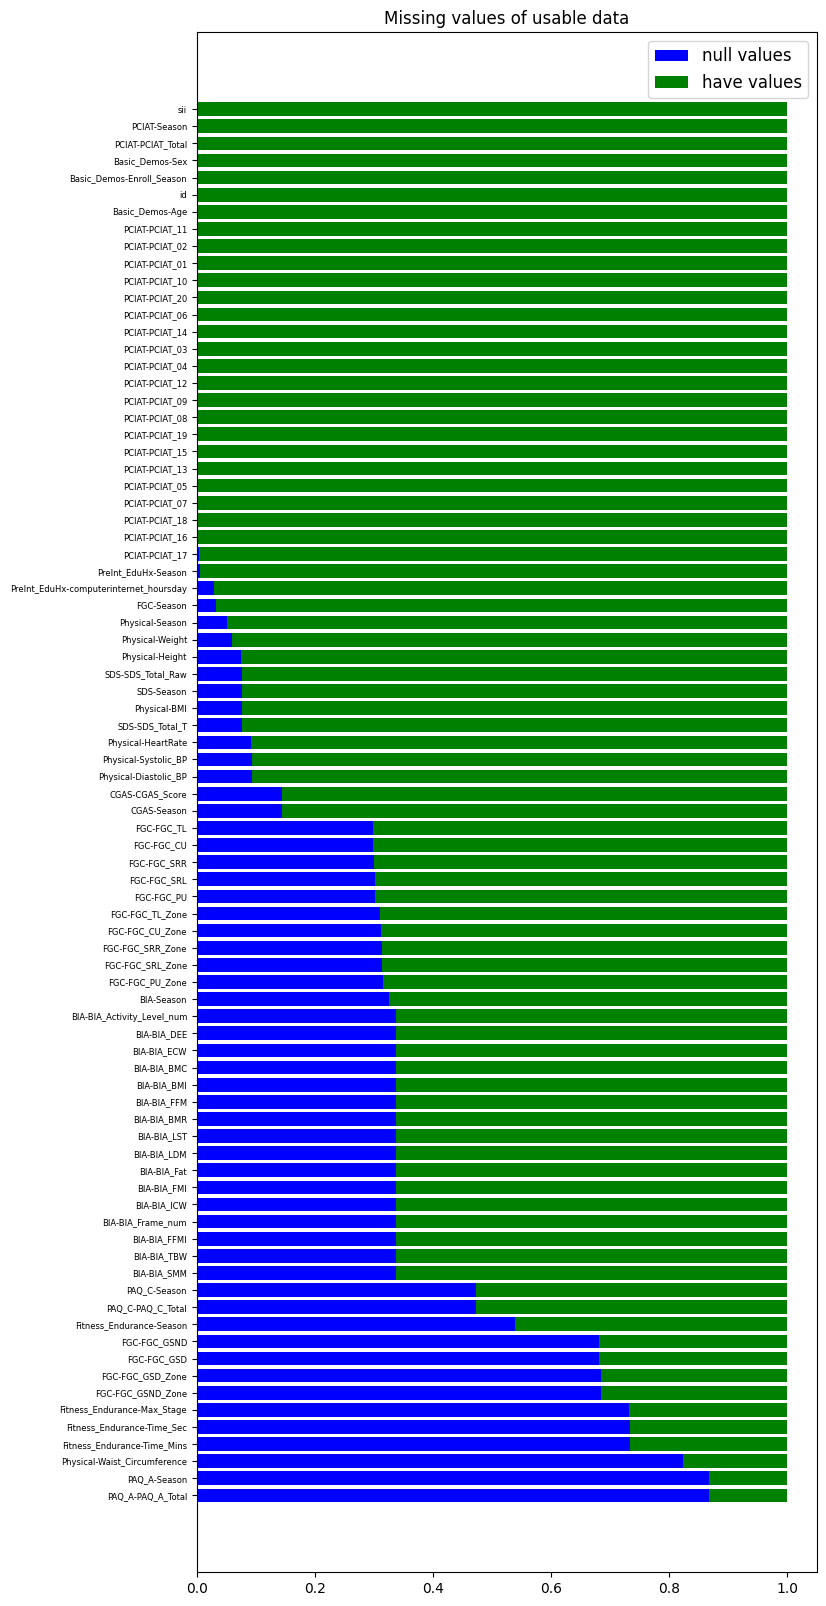

In [6]:
# check null values
import matplotlib.pyplot as plt
plt.figure(figsize=(8,20))
plt.title("Missing values of usable data")
plt.barh(np.arange(len(missing_count)), 
         missing_count['null_ratio'], 
         color='blue', 
         label='null values')
plt.barh(np.arange(len(missing_count)), 
        1 - missing_count['null_ratio'], 
        color='green', 
        left=missing_count['null_ratio'], 
        label='have values')
plt.yticks(np.arange(len(missing_count)), missing_count['feature'], fontsize=6)
plt.legend(fontsize=12)
plt.show()

In [7]:
print("numbers of nan sii: ", train['sii'].isnull().sum())
print( (train.groupby('sii')['PCIAT-PCIAT_Total']
           .agg(PCIAT_Total_min=('min'),
                PCIAT_Total_max=('max'),
                count=('count'))
           .reset_index()
           .sort_values('sii')
        )
     )
corr_pciat_total_sii = train[['PCIAT-PCIAT_Total', 'sii']].corr()
corr_pciat_total_sii

numbers of nan sii:  1224
   sii  PCIAT_Total_min  PCIAT_Total_max  count
0  0.0              0.0             30.0   1594
1  1.0             31.0             49.0    730
2  2.0             50.0             79.0    378
3  3.0             80.0             93.0     34


,PCIAT-PCIAT_Total,sii
PCIAT-PCIAT_Total,1.000000,0.899681
sii,0.899681,1.000000


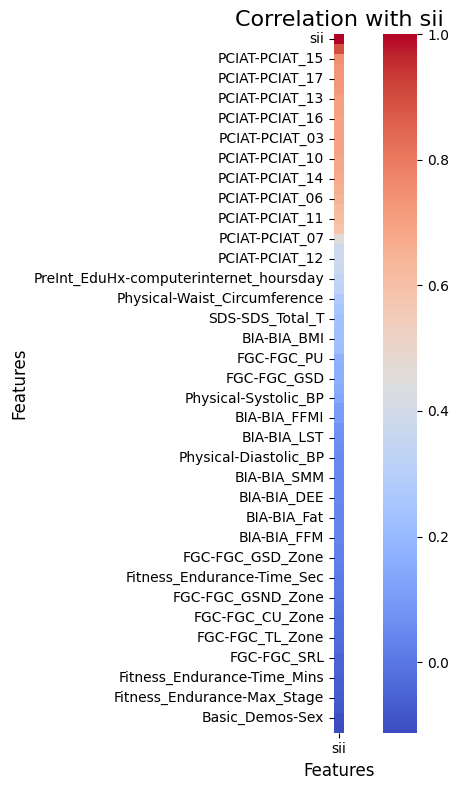

In [10]:
# corr
data = usable_data.select_dtypes(include=[np.number])
data_corr = data.corr()


PPT_corr = data_corr[['sii']].sort_values(by='sii', ascending=False)


plt.figure(figsize=(8, 8))
sns.heatmap(
    PPT_corr,       
    cmap='coolwarm',  
    fmt=".2f",         
    cbar=True,         
    square=True,
    annot=False 
)


plt.title('Correlation with sii', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()


In [9]:
data_parquet = pd.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=00115b9f/part-0.parquet')
data_parquet

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,0.021536,0.022214,-1.022370,0.022853,-88.280762,0.0,53.000000,4188.000000,56940000000000,4,3,41.0
1,1,0.022005,0.022187,-1.019740,0.020231,-88.241707,0.0,51.666668,4188.166504,56945000000000,4,3,41.0
2,2,0.022240,0.022005,-1.019401,0.019893,-88.170067,0.0,50.333332,4188.333496,56950000000000,4,3,41.0
3,3,0.021589,0.022578,-1.018177,0.018667,-88.250031,0.0,50.500000,4188.500000,56955000000000,4,3,41.0
4,4,0.022005,0.023763,-1.014323,0.016848,-88.130775,0.0,33.166668,4181.000000,57235000000000,4,3,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43325,43325,-0.008333,-0.023620,-1.006901,0.007224,-88.595741,0.0,0.000000,3824.000000,57580000000000,6,3,85.0
43326,43326,0.048730,-0.076725,-0.953776,0.056839,-85.352219,0.0,0.000000,3824.000000,57640000000000,6,3,85.0
43327,43327,0.387370,0.793151,-0.402214,0.069961,-24.097908,0.0,0.000000,3824.000000,57645000000000,6,3,85.0
43328,43328,0.801953,0.501589,-0.040937,0.045489,-2.113776,0.0,0.000000,3824.000000,57650000000000,6,3,85.0


In [10]:
data_parquet_null = data_parquet.isnull().sum()
data_parquet_null

step                   0
X                      0
Y                      0
Z                      0
enmo                   0
anglez                 0
non-wear_flag          0
light                  0
battery_voltage        0
time_of_day            0
weekday                0
quarter                0
relative_date_PCIAT    0
dtype: int64

In [11]:
####### BEGIN
# features engineering 
def convert_timeofday(actigraphy_df):
    actigraphy_df['hour'] = (actigraphy_df['time_of_day'] / 1e9) / 3600
    actigraphy_df['hour'] = actigraphy_df['hour'] % 24 
    return actigraphy_df


def features_engineering_data (actigraphy_df):
    actigraphy_df = convert_timeofday(actigraphy_df)
    night_query = ((actigraphy_df['hour'] >= 0) & (actigraphy_df['hour'] <= 6)) | ((actigraphy_df['hour'] >= 22) & (actigraphy_df['hour'] < 24)) 
    day_query = ~night_query
    
    features_df = pd.DataFrame()

    ## daily summary
    daily_features = actigraphy_df.groupby(['weekday'])[['enmo', 'anglez']].agg(['mean', 'std', 'max', 'min']).reset_index()
    daily_features.columns = ['weekday'] + [f'daily_{col}_{stat}' for col in ['enmo', 'anglez'] for stat in ['mean', 'std', 'max', 'min']]

    
    daily_features_columns = daily_features.drop('weekday', axis=1).columns
    flatten_features_columns = [f'{col}_{i+1}' for i in range (daily_features['weekday'].nunique()) for col in daily_features_columns ]


    # flatten dataframe
    flatten_daily_features = daily_features.drop('weekday', axis=1).values.flatten()
    features_df = pd.DataFrame([flatten_daily_features], columns=flatten_features_columns)
    

    ## Night hour
    night_df = actigraphy_df[night_query]
    day_df = actigraphy_df[day_query]
    features_df['avg_night_light'] = night_df['light'].mean()
    features_df['avg_night_enmo'] = night_df['enmo'].mean()
    features_df['night_light_diff_count'] = (night_df['light'].diff() > 0.2).sum()

    # difference between enmo and light day and night
    features_df['diff_day_night_enmo'] = day_df['enmo'].mean() - night_df['enmo'].mean()
    features_df['diff_day_night_light'] = day_df['light'].mean() - night_df['light'].mean()
    
    
    # Interaction between light and enmo at night
    features_df['light_enmo_interaction'] = features_df['avg_night_light']*features_df['avg_night_enmo']
    
    ## Number of times anglez and enmo decrease
    features_df['anglez_diff_count'] = (actigraphy_df['anglez'].diff().abs() > 5 ).sum()
    features_df['enmo_diff_count'] = (actigraphy_df['enmo'].diff() > 0.1).sum()

    # Trend analysis, Trend in activity intensity over time
    trend_enmo = linregress(range(len(actigraphy_df)), actigraphy_df['enmo'])[0]
    features_df['enmo_trend_slope'] = trend_enmo

    
    return features_df 
    

# def create_feature_csv(df):
#     season_cols = [col for col in df.columns if 'Season' in col]
#     df = df.drop(season_cols, axis=1) 

    
#     # Relationship between daily internet usage time and age
#     # => helps the model understand internet usage habits at different ages
#     df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    
#     # Big waist, likely to sit at the computer a lot
#     df['Physical-Waist_Age'] = df['Basic_Demos-Age'] * df['Physical-Waist_Circumference']
#     df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
   

#     # Association between depression level and internet usage time
#     df['SDS_InternetHours'] = df['SDS-SDS_Total_T'] * df['PreInt_EduHx-computerinternet_hoursday']

#     # People with high BMI and depressive symptoms may experience problems related to excessive internet use
#     df['SDS_BMI'] = df['BIA-BIA_BMI'] * df['SDS-SDS_Total_T']
    
#     # The CGAS score measures symptoms of anxiety and stress, which, combined with the SDS, helps to
#         # understand the severity of depression and anxiety. These factors may increase the likelihood of internet addiction
#     df['CGAS_SDS'] = df['CGAS-CGAS_Score'] * df['SDS-SDS_Total_T']

#     # Physical activity levels combined with the SDS can help identify people who are sedentary and experiencing depression
#     df['SDS_Activity'] = df['BIA-BIA_Activity_Level_num'] * df['SDS-SDS_Total_T']

    

#     df['PAQ_A_Activity'] = df['BIA-BIA_Activity_Level_num'] * df['PAQ_A-PAQ_A_Total']
#     df['Activity_CU_PU'] = df['BIA-BIA_Activity_Level_num'] * df['FGC-FGC_CU'] * df['FGC-FGC_PU']

#     # The relationship between social activity and physical activity may indicate
#         # how much people engage in outdoor activities,
#         # which in turn influences their internet use behavior
#     df['FGC_CU_PU'] = df['FGC-FGC_CU'] * df['FGC-FGC_PU']

#     # The combination of social activity, physical activity, and age can help
#         # predict the level of participation in social and physical activities by
#         # age, which in turn determines the likelihood of internet use
#     df['FGC_CU_PU_Age'] = df['FGC-FGC_CU'] * df['FGC-FGC_PU'] * df['Basic_Demos-Age']

#     # Combining CGAS scores with social and physical activities may help to identify
#         # people who show signs of depression but are less engaged in
#         # physical and social activities, and may therefore use the internet excessively
#         # for entertainment or to avoid psychological problems
#     df['CGAS_CU_PU'] = df['CGAS-CGAS_Score'] * df['FGC-FGC_CU'] * df['FGC-FGC_PU']

#     # 
#     df['PreInt_FGC_CU_PU'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['FGC-FGC_CU'] * df['FGC-FGC_PU']
#     df['Endurance_CU_PU'] = df['Fitness_Endurance-Time_Mins'] * df['FGC-FGC_CU'] * df['FGC-FGC_PU']

#     return df


    

In [12]:
actigraphy_df  = pd.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0745c390/part-0.parquet')
daily_features = actigraphy_df.groupby(['weekday'])[['enmo', 'anglez']].agg(['mean', 'std', 'max', 'min']).reset_index()
daily_features.columns = ['weekday'] + [f'daily_{col}_{stat}' for col in ['enmo', 'anglez'] for stat in ['mean', 'std', 'max', 'min']]
daily_features

,weekday,daily_enmo_mean,daily_enmo_std,daily_enmo_max,daily_enmo_min,daily_anglez_mean,daily_anglez_std,daily_anglez_max,daily_anglez_min
0,1,0.061730,0.160617,2.911209,0.0,-16.972418,33.799191,85.449303,-89.002747
1,2,0.027587,0.024546,0.366416,0.0,-22.211037,41.558800,88.871178,-85.694481
2,3,0.031753,0.114930,5.314874,0.0,-10.630747,27.006554,88.520424,-89.777763
3,4,0.029565,0.081234,2.561411,0.0,2.392000,27.655855,88.227806,-89.805885
4,5,0.059546,0.183027,3.665113,0.0,-9.800983,36.715656,89.422226,-89.933327
5,6,0.034805,0.082153,2.179437,0.0,-9.559110,30.970709,88.175079,-89.987045
6,7,0.051783,0.119170,3.044225,0.0,-0.645862,44.180618,89.171806,-89.575623


In [13]:
actigraphy_df= features_engineering_data(actigraphy_df)
actigraphy_df

,daily_enmo_mean_1,daily_enmo_std_1,daily_enmo_max_1,daily_enmo_min_1,daily_anglez_mean_1,daily_anglez_std_1,daily_anglez_max_1,daily_anglez_min_1,daily_enmo_mean_2,daily_enmo_std_2,daily_enmo_max_2,daily_enmo_min_2,daily_anglez_mean_2,daily_anglez_std_2,daily_anglez_max_2,daily_anglez_min_2,daily_enmo_mean_3,daily_enmo_std_3,daily_enmo_max_3,daily_enmo_min_3,daily_anglez_mean_3,daily_anglez_std_3,daily_anglez_max_3,daily_anglez_min_3,daily_enmo_mean_4,daily_enmo_std_4,daily_enmo_max_4,daily_enmo_min_4,daily_anglez_mean_4,daily_anglez_std_4,daily_anglez_max_4,daily_anglez_min_4,daily_enmo_mean_5,daily_enmo_std_5,daily_enmo_max_5,daily_enmo_min_5,daily_anglez_mean_5,daily_anglez_std_5,daily_anglez_max_5,daily_anglez_min_5,daily_enmo_mean_6,daily_enmo_std_6,daily_enmo_max_6,daily_enmo_min_6,daily_anglez_mean_6,daily_anglez_std_6,daily_anglez_max_6,daily_anglez_min_6,daily_enmo_mean_7,daily_enmo_std_7,daily_enmo_max_7,daily_enmo_min_7,daily_anglez_mean_7,daily_anglez_std_7,daily_anglez_max_7,daily_anglez_min_7,avg_night_light,avg_night_enmo,night_light_diff_count,diff_day_night_enmo,diff_day_night_light,light_enmo_interaction,anglez_diff_count,enmo_diff_count,enmo_trend_slope
0,0.06173,0.160617,2.911209,0.0,-16.972418,33.799191,85.449303,-89.002747,0.027587,0.024546,0.366416,0.0,-22.211037,41.5588,88.871178,-85.694481,0.031753,0.11493,5.314874,0.0,-10.630747,27.006554,88.520424,-89.777763,0.029565,0.081234,2.561411,0.0,2.392,27.655855,88.227806,-89.805885,0.059546,0.183027,3.665113,0.0,-9.800983,36.715656,89.422226,-89.933327,0.034805,0.082153,2.179437,0.0,-9.55911,30.970709,88.175079,-89.987045,0.051783,0.11917,3.044225,0.0,-0.645862,44.180618,89.171806,-89.575623,13.846364,0.026302,104,0.021279,36.116371,0.36419,17129,1240,-7.330039e-07


In [14]:
## Process file
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))

    # extract features
    actigraphy_df = features_engineering_data(df)
    return actigraphy_df.values.flatten(), filename.split('=')[1], actigraphy_df.columns.tolist()

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes, feature_columns = zip(*results)
    
    df = pd.DataFrame(stats, columns=feature_columns[0])

    df['id'] = indexes
    
    return df

In [15]:
# Load data
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

train_ts



100%|██████████| 2/2 [00:00<00:00,  9.87it/s]


,daily_enmo_mean_1,daily_enmo_std_1,daily_enmo_max_1,daily_enmo_min_1,daily_anglez_mean_1,daily_anglez_std_1,daily_anglez_max_1,daily_anglez_min_1,daily_enmo_mean_2,daily_enmo_std_2,daily_enmo_max_2,daily_enmo_min_2,daily_anglez_mean_2,daily_anglez_std_2,daily_anglez_max_2,daily_anglez_min_2,daily_enmo_mean_3,daily_enmo_std_3,daily_enmo_max_3,daily_enmo_min_3,daily_anglez_mean_3,daily_anglez_std_3,daily_anglez_max_3,daily_anglez_min_3,daily_enmo_mean_4,daily_enmo_std_4,daily_enmo_max_4,daily_enmo_min_4,daily_anglez_mean_4,daily_anglez_std_4,daily_anglez_max_4,daily_anglez_min_4,daily_enmo_mean_5,daily_enmo_std_5,daily_enmo_max_5,daily_enmo_min_5,daily_anglez_mean_5,daily_anglez_std_5,daily_anglez_max_5,daily_anglez_min_5,daily_enmo_mean_6,daily_enmo_std_6,daily_enmo_max_6,daily_enmo_min_6,daily_anglez_mean_6,daily_anglez_std_6,daily_anglez_max_6,daily_anglez_min_6,daily_enmo_mean_7,daily_enmo_std_7,daily_enmo_max_7,daily_enmo_min_7,daily_anglez_mean_7,daily_anglez_std_7,daily_anglez_max_7,daily_anglez_min_7,avg_night_light,avg_night_enmo,night_light_diff_count,diff_day_night_enmo,diff_day_night_light,light_enmo_interaction,anglez_diff_count,enmo_diff_count,enmo_trend_slope,id
0,0.061730,0.160617,2.911209,0.0,-16.972418,33.799191,85.449303,-89.002747,0.027587,0.024546,0.366416,0.0,-22.211037,41.558800,88.871178,-85.694481,0.031753,0.114930,5.314874,0.0,-10.630747,27.006554,88.520424,-89.777763,0.029565,0.081234,2.561411,0.000000,2.392000,27.655855,88.227806,-89.805885,5.954563e-02,0.183027,3.665113,0.0,-9.800983,36.715656,89.422226,-89.933327,0.034805,0.082153,2.179437,0.000000,-9.559110,30.970709,88.175079,-89.987045,0.051783,0.119170,3.044225,0.000000,-0.645862,44.180618,89.171806,-89.575623,13.846364,0.026302,104.0,0.021279,36.116371,0.364190,17129.0,1240.0,-7.330039e-07,0745c390
1,0.016735,0.054160,2.549117,0.0,1.384454,49.712921,88.547768,-89.167404,0.031702,0.099620,3.218909,0.0,-2.151563,42.818718,88.266830,-88.709015,0.025811,0.077240,3.000422,0.0,-0.301086,42.245800,88.821129,-88.477577,0.033456,0.117695,3.706702,0.000000,-9.525567,37.651779,88.229233,-88.672356,2.707655e-02,0.091497,2.138516,0.0,-15.893749,49.340710,89.080330,-89.654587,0.036004,0.116287,3.538796,0.000000,-9.738598,42.347504,86.692108,-89.293831,0.034731,0.111233,3.966906,0.000000,-7.375295,38.688839,88.062782,-87.507423,12.159246,0.004999,8.0,0.036211,66.916718,0.060787,92217.0,6956.0,-3.637164e-08,eaab7a96
2,0.059420,0.115213,2.310032,0.0,-10.846599,27.876192,77.991013,-89.338921,0.064523,0.109704,1.665057,0.0,-16.568945,29.451048,76.500107,-89.503937,0.066022,0.194993,5.066334,0.0,-12.264791,26.323099,83.378029,-88.064056,0.045652,0.097012,2.057606,0.000000,-10.219858,26.528410,86.987267,-89.435318,5.952546e-02,0.117593,2.368807,0.0,-17.570662,31.160872,86.758675,-89.205505,0.018577,0.002678,0.024243,0.015359,-88.633736,0.932438,-86.831367,-89.540176,0.013217,0.007625,0.026856,0.008082,-88.831184,0.461458,-88.214905,-89.221680,9.167626,0.039015,334.0,0.021595,83.942734,0.357678,18445.0,1850.0,6.748372e-09,8ec2cc63
3,0.061504,0.118945,6.134459,0.0,-9.124672,32.177677,89.356842,-89.063240,0.035932,0.065480,1.585118,0.0,-17.966722,35.785919,89.398727,-88.866920,0.061164,0.104979,2.946331,0.0,-13.204923,30.107317,86.201210,-89.347870,0.041928,0.062618,1.515621,0.000000,-11.150409,32.629723,89.976074,-89.321877,5.322568e-02,0.111489,3.328493,0.0,-16.074749,29.402262,89.652817,-86.919136,0.056243,0.117692,4.089452,0.000000,-12.499669,32.289345,88.182243,-89.778259,0.058097,0.106426,3.464365,0.000000,-10.996117,34.441589,87.861481,-89.968369,3.764740,0.019597,297.0,0.038028,6.278726,0.073776,114254.0,7352.0,2.203514e-08,b2987a65
4,0.049906,0.053567,0.241019,0.0,24.203066,65.893654,87.151680,-89.580948,0.031811,0.051238,1.363104,0.0,-7.081102,48.521149,88.764412,-89.684715,0.048568,0.124128,2.183851,0.0,-26.720556,40.992706,87.198425,-88.805016,0.045647,0.024212,0.294766,0.000000,39.324402,37.148849,89.075607,-89.281181,2.012540e-02,0.027089,0.216001,0.0,-

In [16]:
# imputed missing value on timeseries
imputed_train_ts = train_ts.drop('id', axis=1)
imputed_test_ts = test_ts.drop('id', axis=1)


imputed_train_ts_cols = imputed_train_ts.columns
imputed_test_ts_cols = imputed_test_ts.columns

ts_imputer = SimpleImputer(strategy = 'mean')
ts_imputer.fit(imputed_train_ts)

imputed_train_ts = ts_imputer.transform(imputed_train_ts)
imputed_test_ts = ts_imputer.transform(imputed_test_ts)

imputed_train_ts = pd.DataFrame(imputed_train_ts, columns = imputed_train_ts_cols)
imputed_test_ts = pd.DataFrame(imputed_test_ts, columns = imputed_test_ts_cols)

imputed_train_ts['id'] = train_ts['id']
imputed_test_ts['id'] = test_ts['id']

train_ts = imputed_train_ts
test_ts = imputed_test_ts

In [17]:
# scale data on timeseries
scale_train_ts = train_ts.drop('id', axis=1)
scale_test_ts = test_ts.drop('id', axis=1)

scale_train_ts_cols = scale_train_ts.columns
scale_test_ts_cols = scale_test_ts.columns


scaler = MinMaxScaler()
scaler.fit(scale_train_ts)
scaler.transform(scale_train_ts)
scaler.transform(scale_test_ts)


scale_train_ts = pd.DataFrame(scaler.transform(scale_train_ts), columns = scale_train_ts_cols)
scale_test_ts = pd.DataFrame(scaler.transform(scale_test_ts), columns = scale_test_ts_cols)

scale_train_ts['id'] = train_ts['id']
scale_test_ts['id'] = test_ts['id']

scale_train_ts

,daily_enmo_mean_1,daily_enmo_std_1,daily_enmo_max_1,daily_enmo_min_1,daily_anglez_mean_1,daily_anglez_std_1,daily_anglez_max_1,daily_anglez_min_1,daily_enmo_mean_2,daily_enmo_std_2,daily_enmo_max_2,daily_enmo_min_2,daily_anglez_mean_2,daily_anglez_std_2,daily_anglez_max_2,daily_anglez_min_2,daily_enmo_mean_3,daily_enmo_std_3,daily_enmo_max_3,daily_enmo_min_3,daily_anglez_mean_3,daily_anglez_std_3,daily_anglez_max_3,daily_anglez_min_3,daily_enmo_mean_4,daily_enmo_std_4,daily_enmo_max_4,daily_enmo_min_4,daily_anglez_mean_4,daily_anglez_std_4,daily_anglez_max_4,daily_anglez_min_4,daily_enmo_mean_5,daily_enmo_std_5,daily_enmo_max_5,daily_enmo_min_5,daily_anglez_mean_5,daily_anglez_std_5,daily_anglez_max_5,daily_anglez_min_5,daily_enmo_mean_6,daily_enmo_std_6,daily_enmo_max_6,daily_enmo_min_6,daily_anglez_mean_6,daily_anglez_std_6,daily_anglez_max_6,daily_anglez_min_6,daily_enmo_mean_7,daily_enmo_std_7,daily_enmo_max_7,daily_enmo_min_7,daily_anglez_mean_7,daily_anglez_std_7,daily_anglez_max_7,daily_anglez_min_7,avg_night_light,avg_night_enmo,night_light_diff_count,diff_day_night_enmo,diff_day_night_light,light_enmo_interaction,anglez_diff_count,enmo_diff_count,enmo_trend_slope,id
0,0.375875,0.354471,0.398920,0.0,0.408077,0.400255,0.974623,0.005607,0.084978,0.026935,0.035723,0.0,0.377541,0.488192,0.043471,0.006845,0.000792,0.125284,0.010504,0.006062,0.361208,0.313701,0.020979,0.000232,0.001076,0.085302,0.017425,0.000000,0.381833,0.326752,0.011917,0.000147,4.974086e-04,0.282852,0.004906,0.330354,0.448568,0.442153,0.012183,0.000055,0.008142,0.143238,0.094756,0.000000,0.259058,0.359239,0.007084,0.000005,0.000744,0.204053,0.025572,0.000000,0.498281,0.508231,0.006928,0.000220,0.075598,0.156487,0.003753,0.514909,0.155908,0.045009,0.071080,0.033052,0.840365,0745c390
1,0.101873,0.119509,0.349301,0.0,0.511602,0.588738,0.991973,0.004681,0.097653,0.109353,0.313822,0.0,0.490382,0.502993,0.043324,0.002052,0.000643,0.084190,0.005930,0.006062,0.408762,0.490716,0.021014,0.001672,0.001218,0.123592,0.025216,0.000000,0.332360,0.444906,0.011917,0.001006,2.261840e-04,0.141395,0.002863,0.330354,0.414100,0.594668,0.012159,0.000283,0.008423,0.202759,0.153859,0.000000,0.258476,0.491531,0.007025,0.000293,0.000499,0.190462,0.033326,0.000000,0.460447,0.445057,0.006885,0.001294,0.066387,0.029743,0.000289,0.576882,0.208699,0.007513,0.385185,0.186152,0.861012,eaab7a96
2,0.361806,0.254259,0.316538,0.0,0.442624,0.330103,0.932858,0.003717,0.198754,0.120423,0.162332,0.0,0.409279,0.345962,0.040447,0.000789,0.001646,0.212580,0.010013,0.006062,0.353685,0.305762,0.020371,0.002130,0.001662,0.101871,0.013997,0.000000,0.329478,0.313426,0.011833,0.000428,4.972402e-04,0.181726,0.003171,0.330354,0.404613,0.375049,0.012001,0.000650,0.004346,0.004660,0.001052,0.186309,0.002506,0.009946,0.000084,0.000191,0.000190,0.013043,0.000216,0.178811,0.002493,0.005308,0.000021,0.000404,0.050053,0.232126,0.012052,0.516220,0.237881,0.044205,0.076585,0.049391,0.862290,8ec2cc63
3,0.374495,0.262495,0.840616,0.0,0.452335,0.381050,0.996504,0.005266,0.110685,0.071874,0.154538,0.0,0.401416,0.420378,0.043600,0.001801,0.001525,0.114435,0.005823,0.006062,0.349357,0.349718,0.020705,0.000708,0.001527,0.065752,0.010310,0.000000,0.325615,0.385544,0.012035,0.000514,4.446161e-04,0.172292,0.004456,0.330354,0.413076,0.353804,0.012198,0.002521,0.013157,0.205209,0.177800,0.000000,0.249518,0.374572,0.007084,0.000092,0.000835,0.182230,0.029102,0.000000,0.440090,0.396198,0.006877,0.000016,0.020555,0.116592,0.010717,0.584423,0.104767,0.009118,0.477369,0.196759,0.862743,b2987a65
4,0.303873,0.118200,0.033012,0.0,0.640289,0.780383,0.984156,0.002356,0.097989,0.056239,0.132893,0.0,0.462651,0.569979,0.043445,0.000501,0.001211,0.135313,0.004316,0.006062,0.287136,0.476160,0.020823,0.001309,0.001662,0.025419,0.002005,0.000000,0.535149,0.438961,0.011974,0.000545,1.681188e-04,0.041855,0.000289,0.330354,0.159673,0.553903,0.012050,0.002285,0.011303,0.195943,0.120623,0.000000,0.501888,0.414956,0.007129,0.000095,0.000575,0.148765

In [18]:
# list features of time series data not include id
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")
time_series_cols


# train = create_feature_csv(train)
# train = train.dropna(thresh=10, axis=0)
# test = create_feature_csv(test)


# merge csv and time series data base on id
train_merge = pd.merge(train, scale_train_ts, how="left", on='id')
test_merge = pd.merge(test, scale_test_ts, how="left", on='id')

train_merge


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,daily_enmo_mean_1,daily_enmo_std_1,daily_enmo_max_1,daily_enmo_min_1,daily_anglez_mean_1,daily_anglez_std_1,daily_anglez_max_1,daily_anglez_min_1,daily_enmo_mean_2,daily_enmo_std_2,daily_enmo_max_2,daily_enmo_min_2,daily_anglez_mean_2,daily_anglez_std_2,daily_anglez_max_2,daily_anglez_min_2,daily_enmo_mean_3,daily_enmo_std_3,daily_enmo_max_3,daily_enmo_min_3,daily_anglez_mean_3,daily_anglez_std_3,daily_anglez_max_3,daily_anglez_min_3,daily_enmo_mean_4,daily_enmo_std_4,daily_enmo_max_4,daily_enmo_min_4,daily_anglez_mean_4,daily_anglez_std_4,daily_anglez_max_4,daily_anglez_min_4,daily_enmo_mean_5,daily_enmo_std_5,daily_enmo_max_5,daily_enmo_min_5,daily_anglez_mean_5,daily_anglez_std_5,daily_anglez_max_5,daily_anglez_min_5,daily_enmo_mean_6,daily_enmo_std_6,daily_enmo_max_6,daily_enmo_min_6,daily_anglez_mean_6,daily_anglez_std_6,daily_anglez_max_6,daily_anglez_min_6,daily_enmo_mean_7,daily_enmo_std_7,daily_enmo_max_7,daily_enmo_min_7,daily_anglez_mean_7,daily_anglez_std_7,daily_anglez_max_7,daily_anglez_min_7,avg_night_light,avg_night_enmo,night_light_diff_count,diff_day_night_enmo,diff_day_night_light,light_enmo_interaction,anglez_diff_count,enmo_diff_count,enmo_trend_slope
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,Na

In [19]:
# drop id and seasons features
season_cols_train = [col for col in train_merge.columns if 'Season' in col]
season_cols_test = [col for col in test_merge.columns if 'Season' in col]
drop_cols_train = season_cols_train + ['id']
drop_cols_test  = season_cols_test + ['id']
train_drop = train_merge.drop(drop_cols_train, axis=1)
test_drop = test_merge.drop(drop_cols_test, axis=1)

print(test_drop.shape) # (20, 144)
print(train_drop.shape) # (3960, 166)

(20, 113)
(3960, 135)


In [20]:
# choose features
featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD',
                'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 
                'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 
                'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 
                'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 
                'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 'sii'] + time_series_cols

train = train_drop[featuresCols]
train = train.dropna(subset='sii')

test = test_drop[[c for c in featuresCols if c !="sii"]]


print(train.shape) # (2736, 145)
print(test.shape) # (20, 144)

# Check if any columns contain non-numeric data
non_numeric_train = train.select_dtypes(exclude=['number']).columns
non_numeric_test = test.select_dtypes(exclude=['number']).columns

train = train.drop(non_numeric_train, axis=1)
test = test.drop(non_numeric_test, axis=1)
print(train.shape) # (2736, 145)
print(test.shape) # (20, 144)


# scaler = StandardScaler()
# train = scaler.fit_transform(train)
# train = pd.DataFrame(train)
train



(2736, 114)
(20, 113)
(2736, 114)
(20, 113)


,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,daily_enmo_mean_1,daily_enmo_std_1,daily_enmo_max_1,daily_enmo_min_1,daily_anglez_mean_1,daily_anglez_std_1,daily_anglez_max_1,daily_anglez_min_1,daily_enmo_mean_2,daily_enmo_std_2,daily_enmo_max_2,daily_enmo_min_2,daily_anglez_mean_2,daily_anglez_std_2,daily_anglez_max_2,daily_anglez_min_2,daily_enmo_mean_3,daily_enmo_std_3,daily_enmo_max_3,daily_enmo_min_3,daily_anglez_mean_3,daily_anglez_std_3,daily_anglez_max_3,daily_anglez_min_3,daily_enmo_mean_4,daily_enmo_std_4,daily_enmo_max_4,daily_enmo_min_4,daily_anglez_mean_4,daily_anglez_std_4,daily_anglez_max_4,daily_anglez_min_4,daily_enmo_mean_5,daily_enmo_std_5,daily_enmo_max_5,daily_enmo_min_5,daily_anglez_mean_5,daily_anglez_std_5,daily_anglez_max_5,daily_anglez_min_5,daily_enmo_mean_6,daily_enmo_std_6,daily_enmo_max_6,daily_enmo_min_6,daily_anglez_mean_6,daily_anglez_std_6,daily_anglez_max_6,daily_anglez_min_6,daily_enmo_mean_7,daily_enmo_std_7,daily_enmo_max_7,daily_enmo_min_7,daily_anglez_mean_7,daily_anglez_std_7,daily_anglez_max_7,daily_anglez_min_7,avg_night_light,avg_night_enmo,night_light_diff_count,diff_day_night_enmo,diff_day_night_light,light_enmo_interaction,anglez_diff_count,enmo_diff_count,enmo_trend_slope
0,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.061430,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.211720,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,2.340,46.0,64.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,5.0,7.0,33.0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.170,38.0,54.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,6.0,9.0,37.0,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.220330,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,2.451,31.0,45.0,0.0,1.0,0.192325,0.147619,0.163201,0.0,0.433958,0.337218,0.986883,0.007691,0.120756,0.087678,0.158621,0.0,0.441553,0.469136,0.041993,0.002846,0.001184,0.091973,0.002516,0.006062,0.296138,0.504409,0.021124,0.000171,0.0025

In [21]:
# Evaluate machine learning models and process regression predictions into threshold-based classifications
def quadratic_weighted_kappa(y_true, y_pred):
    # Cohen's Kappa is an index used to evaluate the level of agreement between two
        # evaluators (or two methods) when classifying objects into groups
    # Quadratic weighting, meaning that the further apart the classification errors are, the greater their weight
    # => Predicting 0 and the actual value is 3 will be penalized more severely than predicting 2 and the actual value is 3
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(non_rounded_pred, thresholds):
    # Convert continuous predicted values ​​(which can be real values ​​from a regression model)
        # into discrete categorical values ​​based on thresholds
    # non_rounded_pred: These are the regression predicted values
    return np.where(non_rounded_pred < thresholds[0], 0,
           np.where(non_rounded_pred < thresholds[1], 1,
           np.where(non_rounded_pred < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, non_rounded_pred):
    # Evaluate the model by calculating quadratic weighted kappa
        # between the actual labels and the continuous predicted values ​​after
        # applying the classification threshold
    # Minimization objective
    rounded_p = threshold_Rounder(non_rounded_pred, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [22]:
# Train
def train_and_evaluate_model(model_class, test_data):
    
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=1, random_state=SEED)
    
    train_result = []
    test_result = []
    
    non_rounded_pred = np.zeros(len(y), dtype=float) 
    rounded_pred = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        # predict
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Predicted value on val set is not rounded
        non_rounded_pred[test_idx] = y_val_pred
        
        # Round to nearest integer
        y_val_pred_rounded = y_val_pred.round(0).astype(int)

        # Predicted values ​​on the val set have been rounded
        rounded_pred[test_idx] = y_val_pred_rounded

        # Evaluate model performance on train and val sets
        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_result.append(train_kappa)
        test_result.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")

    print(f"Mean Train QWK --> {np.mean(train_result):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_result):.4f}")

    # Find the optimal thresholds, the initial threshold is x0=[0.5, 1.5, 2.5]
    KappaOptimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, non_rounded_pred), 
                              method='Nelder-Mead') 
  

    # KappaOPtimizer.x: are the optimal thresholds that minimize finds.
    predicted_tuned = threshold_Rounder(non_rounded_pred, KappaOptimizer.x)
    # QWK is recalculated after applying the optimal threshold. This is an evaluation metric
        # of the final prediction quality.
    tKappa = quadratic_weighted_kappa(y, predicted_tuned)

    print(f"----> || Optimized QWK SCORE :: {tKappa:.3f}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOptimizer.x)
    
    submission = pd.DataFrame({
        'id': test_merge['id'],
        'sii': tpTuned
    })

    return submission,model,tKappa

In [23]:
# # fine tune model weighting and performance evaluation
# def objective(trial):
#     # Optimize each model individually
#     XGBoostParams = {
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
#         'max_depth': trial.suggest_int('max_depth', 6, 8),
#         'n_estimators': trial.suggest_int('n_estimators', 180, 500),
#         'subsample': trial.suggest_uniform('subsample', 0.7, 0.9),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 0.9),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1, 7),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 3),
#         'tree_method': 'gpu_hist',
#         'random_state': SEED
#     }

#     # CatBoostParams = {
#     #    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),  
#     #    'depth': trial.suggest_int('depth', 6, 8),  
#     #    'iterations': trial.suggest_int('iterations', 200, 400),  
#     #    'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 2, 7),  
#     #    'border_count': 128,  
#     #    'random_seed': SEED, 
#     #    'task_type': 'GPU', 
#     #    'verbose': 0  
#     # }

#     # LgbmParams = {
#     #    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
#     #    'max_depth': trial.suggest_int('max_depth', 10, 14),
#     #    'num_leaves': 60,
#     #    'min_data_in_leaf': 14,
#     #    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 0.9),
#     #    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 0.9),
#     #    'bagging_freq': 2,
#     #    'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 3),
#     #    'lambda_l2': trial.suggest_loguniform('lambda_l2', 1, 6),
#     #    'random_state': 42,
#     #    'verbose': -1,
#     #    'n_estimators': trial.suggest_int('n_estimators', 200, 500)  
#     # }
    
#     # model_class = CatBoostRegressor(**CatBoostParams)
#     # model_class = lgb.LGBMRegressor(**LgbmParams)
#     model_class = XGBRegressor(**XGBoostParams)
#     submission, model, tKappa = train_and_evaluate_model(model_class, test)
   
#     return tKappa
    

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=60)

# print("Best trial:")
# trial = study.best_trial
# print(trial.params)
# print(f"Best QWK Score: {trial.value}")

In [24]:
LGBMParams = {
    'learning_rate': 0.02, 
    'max_depth': 12, 
    'num_leaves': 60, 
    'min_data_in_leaf': 14,
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.75, 
    'bagging_freq': 2, 
    'lambda_l1': 1.6, 
    'lambda_l2': 1.30402
}


XGParams = {
    'learning_rate': 0.02,
    'max_depth': 8,
    'n_estimators': 200,
    'reg_alpha': 6.504,
    'reg_lambda': 0,
    'random_state': SEED,
    'subsample': 0.6338511354509201,
    'colsample_bytree': 0.6224130204928667,
    'tree_method': 'gpu_hist',
    'gpu_id': 0
}

CatBoostParams = {
    'learning_rate': 0.03110795797596136,
    'depth': 8,
    'iterations': 201,
    'random_seed': SEED,
    #'grow_policy': 'Lossguide',
    'verbose': 0,
    'border_count': 128,
    'l2_leaf_reg': 1.065270348122753,  
    'task_type': 'GPU'
}

LightGBM = lgb.LGBMRegressor(**LGBMParams,random_state=SEED, verbose=-1,n_estimators=180) #0.463
XGBoost = XGBRegressor(**XGParams)
CatBoost = CatBoostRegressor(**CatBoostParams)

estimators = [
    ('lightgbm', LightGBM),
    ('xgboost', XGBoost),
    ('catboost', CatBoost),
]

weights = [
    5,
    3,
    5
]

voting_model = VotingRegressor(estimators=estimators, weights = weights)

submission, model, tKappa = train_and_evaluate_model(voting_model, test)
submission.to_csv('submission.csv', index=False)


Training Folds:  20%|██        | 1/5 [00:20<01:23, 20.87s/it]

Fold 1 - Train QWK: 0.7210, Validation QWK: 0.3412


Training Folds:  40%|████      | 2/5 [00:26<00:36, 12.15s/it]

Fold 2 - Train QWK: 0.7252, Validation QWK: 0.4326


Training Folds:  60%|██████    | 3/5 [00:32<00:18,  9.38s/it]

Fold 3 - Train QWK: 0.7339, Validation QWK: 0.4350


Training Folds:  80%|████████  | 4/5 [00:38<00:08,  8.04s/it]

Fold 4 - Train QWK: 0.7370, Validation QWK: 0.3635


Training Folds: 100%|██████████| 5/5 [00:45<00:00,  9.00s/it]

Fold 5 - Train QWK: 0.7360, Validation QWK: 0.3610
Mean Train QWK --> 0.7306
Mean Validation QWK ---> 0.3867


----> || Optimized QWK SCORE :: 0.459
